# Simple Genetic Algorithms

## Overview

Simple genetic algorithms work with a **coding of the parameter set**.

Given an initial random population, SGA uses 3 operators:

1. Reproduction
2. Crossover
3. Mutation


## Objective Functions

The following are the given test objective functions.


### De Jong's Function

(see http://www.geatbx.com/download/GEATbx_ObjFunExpl_v38.pdf page 3)

$$ f_1(x) = \sum_{i=1}^n x_i^2 \qquad -5.12 \leq x_i \leq 5.12 $$
Minimum:
$$  f_1(x)=0; x_i=0 $$

### Rosenbrock's Valley

(see http://www.geatbx.com/download/GEATbx_ObjFunExpl_v38.pdf page 5)

$$ f_2(x) = \sum_{i=1}^{n-1} 100 \cdot (x_{i+1} - x_i^2)^2 + (1-x_i)^2  \qquad  -2.048 \leq x_i \leq 2.048 $$
Minimum: 
$$f_2(x) = 0; x_i = 1$$

### Himmelblau's Function

(see https://en.wikipedia.org/wiki/Himmelblau%27s_function)

$$ f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2 $$

Maximum: 

$x = -0.270845; y = -0.923039; f(x, y) = 181.617$

Minima:

$f(3.0, 2.0) = 0.0$

$f(-2.805118, 3.131312) = 0.0$

$f(-3.779310, -3.283186) = 0.0$

$f(3.584428, -1.848126) = 0.0$

In [1]:
# Converts binary string to integer and squares it
squared_OF = lambda x: int(x, 2) ** 2


def dejong_OF(*xlist):
    return sum(x**2 for x in xlist)


def rosenbrock_OF(*x):
    irange = range(len(x)-1)
    terms = (100 * (x[i+1] - x[i]**2)**2 + (1-x[i])**2 for i in irange)
    return sum(terms)
    

def himmelblau_OF(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


def ESF_OF(coding):
    '''
    Coding defines a sequence of {-1, 1}
    Objective is to find a sequence that yields a result of 0
    '''
    a = [0] + [-1 if bit == '0' else 1 for bit in coding]
    return 10 - abs(
        a[1]*a[2] + a[1]*a[3] + a[1]*a[4] + a[1]*a[5] +
        a[2]*a[3] + a[2]*a[4] + a[2]*a[5] + a[3]*a[4] +
        a[3]*a[5] + a[4]*a[5]
    )

In [2]:
def dejong_decoder(coding):
    n = 4
    bits_list = [coding[i:i+n] for i in range(0, len(coding), n)]
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    xlist = [sign * (num % 5.12) for sign, num in signs_nums]
    return xlist


def rosenbrock_decoder(coding):
    n = 3
    bits_list = [coding[i:i+n] for i in range(0, len(coding), n)]
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    x = [sign * (num % 2.048) for sign, num in signs_nums]
    return x


def himmelblau_decoder(coding):
    mid = int(len(coding)/2)
    binx, biny = coding[:mid], coding[mid:]
    x, y = int(binx, 2), int(biny, 2)
    return x, y


def benchmark_decoder(coding):
    # initial 0 because the benchmark OFs index the array at 1
    return [0] + [-1 if bit == '0' else 1 for bit in coding]

Imports for plotting.

In [3]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## SGA Implementation

First we need utilities to generate the random strings that SGA operates on.

In [4]:
import random
from typing import Callable, List


def random_string(length: int) -> str:
    """
    :param length: [int] length of random string
    :returns: [string] random string consisting of "0" and "1"
    """
    return ''.join('0' if random.random() > 0.5 else '1' for _ in range(length))
    

def generate_sample_population(number=4, length=5) -> List:
    """
    :param number: [default=4] number of strings to return
    :param length: [default=5] length of the strings to return
    :returns: a random list of binary strings
    """
    return [random_string(length) for _ in range(number)]

In [5]:
MIN = 0
MAX = 1


def reproduction(population: List, fitness_func: Callable, min_or_max=MAX) -> List:
    """
    Produces a new population from biased roulette reproduction of the given population.
    """
    # First, we define the probability density (roulette weights) for each
    # member in our given population.    
    def compute_weight(m):
        """
        Subroutine which computes the weight of the biased roulette, which 
        is agnostic of the fitness function. In particular, it will invert
        the fitness value if we are seeking a minimum.
        """
        fitness = fitness_func(m)
        if min_or_max == MAX:
            return fitness
        elif min_or_max == MIN:
            return 1/(fitness+1)
    
    # Here we normalize the weights to be proportions of the total weighting
    weights = [(m, compute_weight(m)) for m in population]
    total_weights = sum(w for m, w in weights)
    pdf = [(m, w/total_weights) for m, w in weights]
    
    # Now we pick members for the new population.
    # We pick the same number of members as the provided population.
    new_population = []
    for i in range(len(population)):
        rand = random.random()
        cumul = 0
        for member, end_interval in pdf:
            cumul += end_interval
            if rand <= cumul:
                new_population.append(member)
                break
    
    return new_population

In [6]:
def crossover(string1, string2, index):
    head1, tail1 = string1[:index], string1[index:]
    head2, tail2 = string2[:index], string2[index:]
    return head1+tail2, head2+tail1

def mutation(string, probability):
    flipped = lambda x: '1' if x is '0' else '0'
    chars = (flipped(c) if random.random() < probability else c for c in string)
    return ''.join(chars)

In [7]:
def population_crossover(population, probability):
    pairs = []
    new_population = []
    while len(population) > 1:
        pairs.append((population.pop(), population.pop()))
    if len(population) == 1:
        new_population.append(population.pop())
        
    for s1, s2 in pairs:
        if random.random() < probability: 
            # don't perform crossover, just add the original pair
            new_population += [s1, s2]
            continue
        idx = random.randint(1, len(s1)-1) # select crossover index
        new_s1, new_s2 = crossover(s1, s2, idx)
        new_population.append(new_s1)
        new_population.append(new_s2)
    return new_population

def mutate_population(population, prob):
    return [mutation(m, prob) for m in population]

In [12]:
# More benchmark ofs

nov10 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10])
nov11 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11])
nov12 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12])
nov20 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20])
nov27 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[3]*a[22]+a[4]*a[22]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[22]+a[2]*a[22]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20]+a[5]*a[22]+a[6]*a[22]+a[7]*a[22]+a[8]*a[22]+a[9]*a[22]+a[10]*a[22]+a[11]*a[22]+a[12]*a[22]+a[13]*a[22]+a[14]*a[22]+a[15]*a[22]+a[16]*a[22]+a[17]*a[22]+a[18]*a[22]+a[19]*a[22]+a[20]*a[22]+a[21]*a[22]+a[1]*a[23]+a[2]*a[23]+a[3]*a[23]+a[4]*a[23]+a[5]*a[23]+a[6]*a[23]+a[7]*a[23]+a[8]*a[23]+a[9]*a[23]+a[10]*a[23]+a[11]*a[23]+a[12]*a[23]+a[13]*a[23]+a[14]*a[23]+a[15]*a[23]+a[16]*a[23]+a[17]*a[23]+a[18]*a[23]+a[19]*a[23]+a[20]*a[23]+a[21]*a[23]+a[22]*a[23]+a[1]*a[24]+a[2]*a[24]+a[3]*a[24]+a[4]*a[24]+a[5]*a[24]+a[6]*a[24]+a[7]*a[24]+a[8]*a[24]+a[9]*a[24]+a[10]*a[24]+a[11]*a[24]+a[12]*a[24]+a[13]*a[24]+a[14]*a[24]+a[15]*a[24]+a[16]*a[24]+a[17]*a[24]+a[18]*a[24]+a[19]*a[24]+a[20]*a[24]+a[21]*a[24]+a[22]*a[24]+a[23]*a[24]+a[1]*a[25]+a[2]*a[25]+a[3]*a[25]+a[4]*a[25]+a[5]*a[25]+a[6]*a[25]+a[7]*a[25]+a[8]*a[25]+a[9]*a[25]+a[10]*a[25]+a[11]*a[25]+a[12]*a[25]+a[13]*a[25]+a[14]*a[25]+a[15]*a[25]+a[16]*a[25]+a[17]*a[25]+a[18]*a[25]+a[19]*a[25]+a[20]*a[25]+a[21]*a[25]+a[22]*a[25]+a[23]*a[25]+a[24]*a[25]+a[1]*a[26]+a[2]*a[26]+a[3]*a[26]+a[4]*a[26]+a[5]*a[26]+a[6]*a[26]+a[7]*a[26]+a[8]*a[26]+a[9]*a[26]+a[10]*a[26]+a[11]*a[26]+a[12]*a[26]+a[13]*a[26]+a[14]*a[26]+a[15]*a[26]+a[16]*a[26]+a[17]*a[26]+a[18]*a[26]+a[19]*a[26]+a[20]*a[26]+a[21]*a[26]+a[22]*a[26]+a[23]*a[26]+a[24]*a[26]+a[25]*a[26]+a[1]*a[27]+a[2]*a[27]+a[3]*a[27]+a[4]*a[27]+a[5]*a[27]+a[6]*a[27]+a[7]*a[27]+a[8]*a[27]+a[9]*a[27]+a[10]*a[27]+a[11]*a[27]+a[12]*a[27]+a[13]*a[27]+a[14]*a[27]+a[15]*a[27]+a[16]*a[27]+a[17]*a[27]+a[18]*a[27]+a[19]*a[27]+a[20]*a[27]+a[21]*a[27]+a[22]*a[27]+a[23]*a[27]+a[24]*a[27]+a[25]*a[27]+a[26]*a[27])


In [32]:
nov = 12
of = nov12

all_binstrings = ["{:0{width}b}".format(i, width=nov) for i in range(2**nov)]
fitness = lambda binstring: of(*benchmark_decoder(binstring))
the_min = min(all_binstrings, key=fitness)
the_max = max(all_binstrings, key=fitness)
print('nov{} =>  min fitness = {}   max fitness = {}'.format(nov, fitness(the_min), fitness(the_max)))

nov12 =>  min fitness = 2   max fitness = 66


Global optimum: 100111100111
OF = 2
Decoded global optimum: [0, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1]


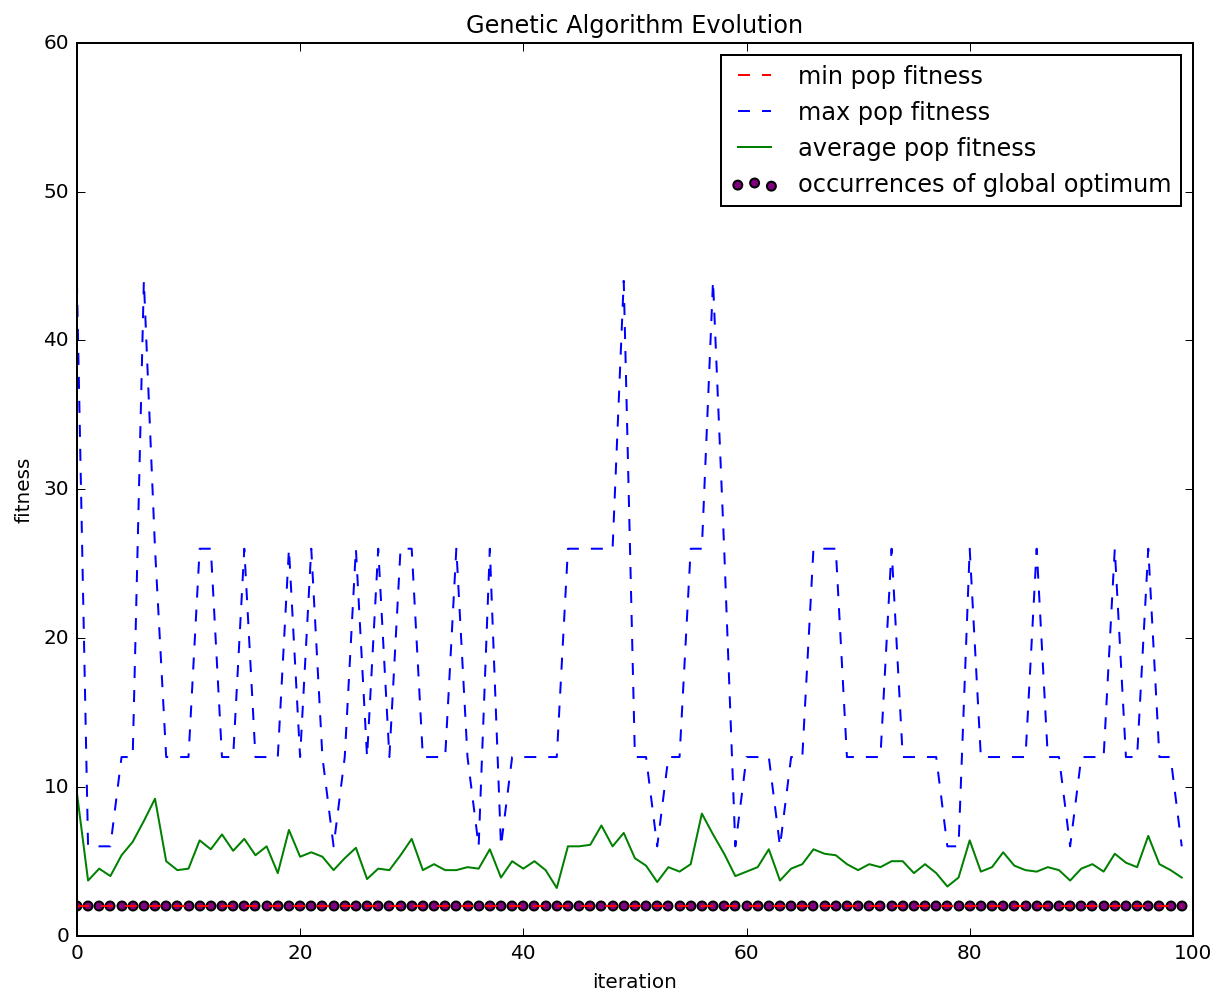

In [40]:
# Define fitness function and probabilistic parameters

member_length = 12
decoder = benchmark_decoder
obj_fun = nov12

min_or_max = MIN
crossover_probability = 0.4
mutation_probability = 0.05
NUM_ERAS = 100
population_size = 20

# Initialize population
population = generate_sample_population(number=population_size, length=member_length)
populations = []

# Fitness function is always defined as
#   output of objective_function
#     where parameter(s) is/are the decoded binary string
def fitness(coding):
    return obj_fun(*decoder(coding))
    
# Perform NUM_ERAS of evolution
for i in range(NUM_ERAS):
    populations.append(population)
    population = reproduction(population, fitness, min_or_max)
    population = population_crossover(population, crossover_probability)
    population = mutate_population(population, mutation_probability)


# The GA execution is done.
# This is stuff for plotting
x_axis = range(len(populations))
fitnesses = [[fitness(m) for m in population] for population in populations]
mins = [min(f) for f in fitnesses]
maxs = [max(f) for f in fitnesses]
avgs = [sum(f)/len(f) for f in fitnesses]

# Find the "global optimum" of all the chromosomes we looked at.
# A better term for this chromosome is "best individual".
all_chromosomes = {c for pop in populations for c in pop}
optimizer = min if min_or_max == MIN else max
global_optimum = optimizer(all_chromosomes, key=fitness)
fittest_fitness = fitness(global_optimum)

#optima = [(it, fittest_fitness) for it, pop in enumerate(populations) if global_optimum in pop]
optima = [(it, fittest_fitness) for it, pop in enumerate(populations) if fittest_fitness in map(fitness, pop)]
x_optima, y_optima = zip(*optima) # unzip pairs into two sequences
line_mins, line_maxs, line_avgs = plt.plot(x_axis, mins, 'r--', maxs, 'b--', avgs, 'g-')
scatter_ceil = plt.scatter(x_optima, y_optima, c='purple')
ymin, ymax = plt.ylim()
plt.ylim(0, round(ymax*1.20))
plt.xlim(0, NUM_ERAS)
plt.legend(
    (line_mins, line_maxs, line_avgs, scatter_ceil), 
    ("min pop fitness", "max pop fitness", "average pop fitness", "occurrences of global optimum"), 
    loc="upper right"
)
plt.title("Genetic Algorithm Evolution")
plt.xlabel('iteration')
plt.ylabel('fitness')

print("Global optimum: {}\nOF = {}".format(global_optimum, fitness(global_optimum)))
print("Decoded global optimum:", decoder(global_optimum))